In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

# 데이터 가져오기 및 확인

In [2]:
path_ko = os.getenv("HOME") + '/aiffel/s2s_translation/korean-english-park.train.ko'
path_en = os.getenv("HOME") + '/aiffel/s2s_translation/korean-english-park.train.en'

In [3]:
with open(path_ko, "r") as f:
    ko = f.read().splitlines()

print("Data Size:", len(ko))
print("Example:")

for sen in ko[0:100][::20]:
    print(">>", sen)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


In [4]:
with open(path_en, "r") as f:
    en = f.read().splitlines()

print("Data Size:", len(en))
print("Example:")

for sen in en[0:100][::20]:
    print(">>", sen)

Data Size: 94123
Example:
>> Much of personal computing is about "can you top this?"
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
>> Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.
>> Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the kind of workout they get from aerobic activities such as brisk walking or running for at least 20 minutes.


In [5]:
raw = zip(ko, en)
cleaned_corpus = set(raw)
len(cleaned_corpus)

78968

병렬쌍으로 적용되는 것 확인 완료. set을 통해 중복을 제거해주고 다시 리스트화 시키기
데이터의 중복 제거만으로 15,155개가 감소한 78968가 되었다

# 데이터전처리 및 토큰화

In [6]:
from konlpy.tag import Mecab
mecab = Mecab()

In [7]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,가-힣0-9 ]+", " ", sentence)

    sentence = sentence.strip()

    # 영어일 때
    if s_token:
        sentence = '<start> ' + sentence
    if e_token:
        sentence += ' <end>'
    
    # 한국어일 때
    if s_token == False:
        sentence = mecab.morphs(sentence)
    else:
        sentence = sentence.split()
        
    return sentence

In [8]:
corpus_list = list(cleaned_corpus)

In [9]:
kor_corpus = []
eng_corpus = []

for pair in corpus_list[:2000]:
    ret_ko = preprocess_sentence(pair[0]) # 한국어
    ret_en = preprocess_sentence(pair[1], s_token=True, e_token=True) # 영어
    if len(ret_ko) <= 30:
        kor_corpus.append(ret_ko)
        eng_corpus.append(ret_en)

print(len(kor_corpus))
print(len(eng_corpus))
print("Korean:", kor_corpus[99])   
print("English:", eng_corpus[99]) # #한국어와 불일치

1117
1117
Korean: ['채', '씨', '는', '숭례문', '이', '경비', '가', '허술', '하', '고', '대중교통', '으로', '접근', '이', '용이', '하', '기', '때문', '에', '이곳', '을', '범행', '장소', '로', '선택', '했', '다고', '밝혔', '다', '.']
English: ['<start>', 'chae', 'said', 'he', 'chose', 'namdaemun', 'because', 'it', 'was', 'easily', 'accessible', 'by', 'public', 'transportation', 'and', 'yet', 'situated', 'in', 'a', 'lightly', 'populated', 'area', 'where', 'the', 'fire', 'was', 'unlikely', 'to', 'hurt', 'people', ',', 'according', 'to', 'police', '.', '<end>']


쌍이 일치하는 문장도 있지만 일치하지 않는 문장이 꽤 있다

In [10]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [11]:
# 토큰화하기
# 훈련 데이터와 검증 데이터로 분리하기

enc_tensor, enc_tokenizer = tokenize(kor_corpus)
dec_tensor, dec_tokenizer = tokenize(eng_corpus)

enc_train, enc_val, dec_train, dec_val = \
train_test_split(enc_tensor, dec_tensor, test_size=0.2)

print("Korean Vocab Size:", len(enc_tokenizer.index_word))
print("English Vocab Size:", len(dec_tokenizer.index_word))

Korean Vocab Size: 5340
English Vocab Size: 5210


# 모델설계

In [12]:
#바다나우어텐션 사용
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [13]:
# 인코더
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        # TODO: Awesome Encoder Modules
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)       
    def call(self, x):
        # TODO: Awesome Process
        out = self.embedding(x)
        out = self.gru(out)
        
        return out

In [14]:
#디코더
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        # TODO: Awesome Decoder Modules
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)
        
        
    def call(self, x, h_dec, enc_out):
        # TODO: Awesome Process
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)

        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [15]:
BATCH_SIZE     = 8
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units         = 512
embedding_dim = 128

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (8, 30, 512)
Decoder Output: (8, 5211)
Decoder Hidden State: (8, 512)
Attention: (8, 30, 1)


# 훈련하기

In [16]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

    #fit 함수를 사용불가능한 이유는 loss함수때문. >>> 일반적이지 않으므로 loss를 직접 커스텀해야함


In [17]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    # tape에 모든 연산을 기록. 후에 그라디언트 계산을 위해 필요
    with tf.GradientTape() as tape:
        #인코더에 소스문장을 전달해 컨텍스트벡터 enc_out 생성
        enc_out = encoder(src)
        #디코더의 h는 인코더의 마지막열
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [19]:
# 훈련
# eval_step() 정의하기
# train_step() 이후 eval_step() 진행하도록 소스 수정하기
import random
@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
    bsz = src.shape[0]
    loss = 0

    enc_out = encoder(src)

    h_dec = enc_out[:, -1]

    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    for t in range(1, tgt.shape[1]):
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        loss += loss_function(tgt[:, t], pred)
        dec_src = tf.expand_dims(tgt[:, t], 1)

    batch_loss = (loss / int(tgt.shape[1]))

    return batch_loss


# Training Process

from tqdm import tqdm

EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % 
                              (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    test_loss = 0

    idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (test_batch, idx) in enumerate(t):
        test_batch_loss = eval_step(enc_val[idx:idx+BATCH_SIZE],
                                    dec_val[idx:idx+BATCH_SIZE],
                                    encoder,
                                    decoder,
                                    dec_tokenizer)

        test_loss += test_batch_loss

        t.set_description_str('Test Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))

Test Epoch 10: 100%|██████████| 28/28 [00:01<00:00, 17.31it/s, Test Loss 2.8264]


In [20]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence)]
    plot_attention(attention, sentence, result.split(' '))

/tmp/ipykernel_415/2245781914.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_415/2245781914.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


Input: ['오바마', '는', '대통령', '이', '다', '.']
Predicted translation: the united states anytime and counterinsurgency operations . <end> 


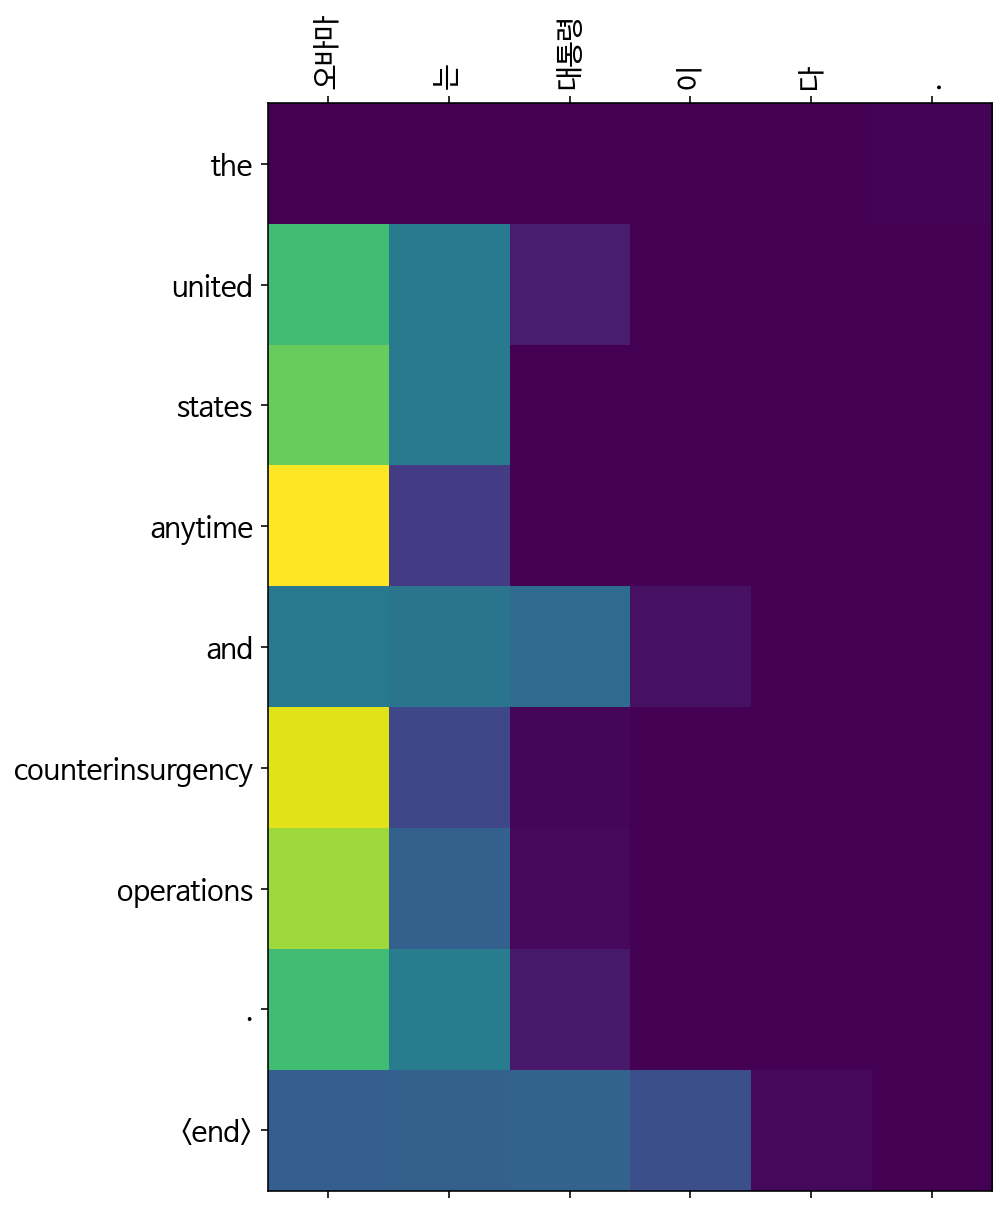

In [21]:
translate("오바마는 대통령이다.", encoder, decoder)

Input: ['시민', '들', '은', '도시', '속', '에', '산다', '.']
Predicted translation: the freedom of the taliban department says <end> 


/tmp/ipykernel_415/2245781914.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_415/2245781914.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


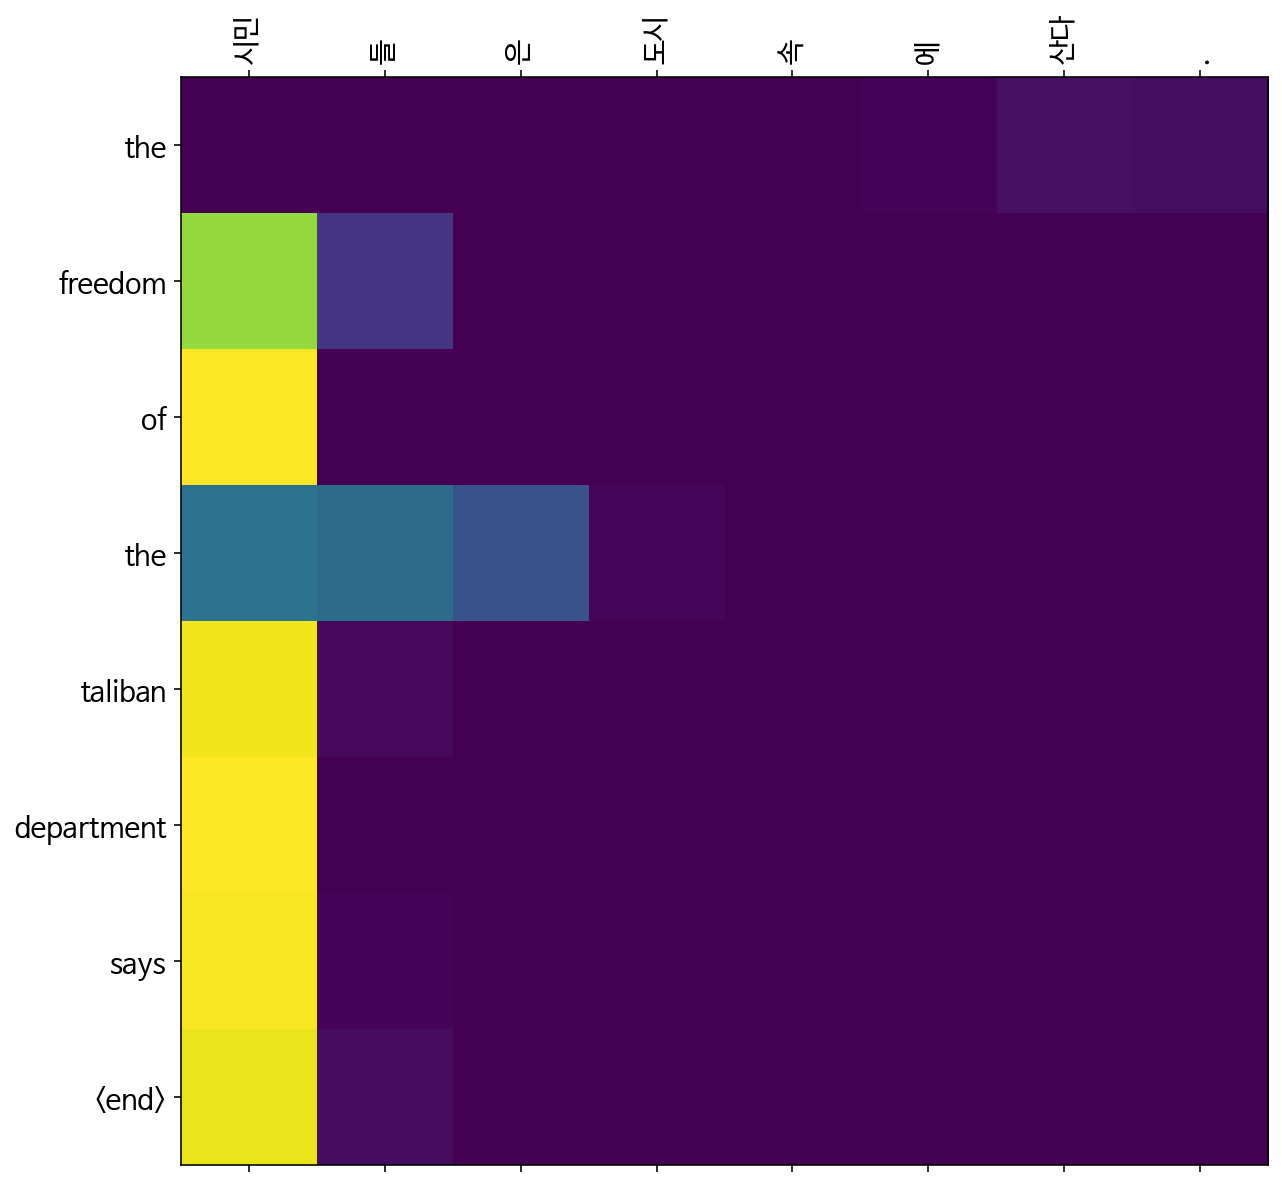

In [22]:
translate("시민들은 도시 속에 산다.", encoder, decoder)

Input: ['커피', '는', '필요', '없', '다', '.']
Predicted translation: the u . s . <end> 


/tmp/ipykernel_415/2245781914.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_415/2245781914.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


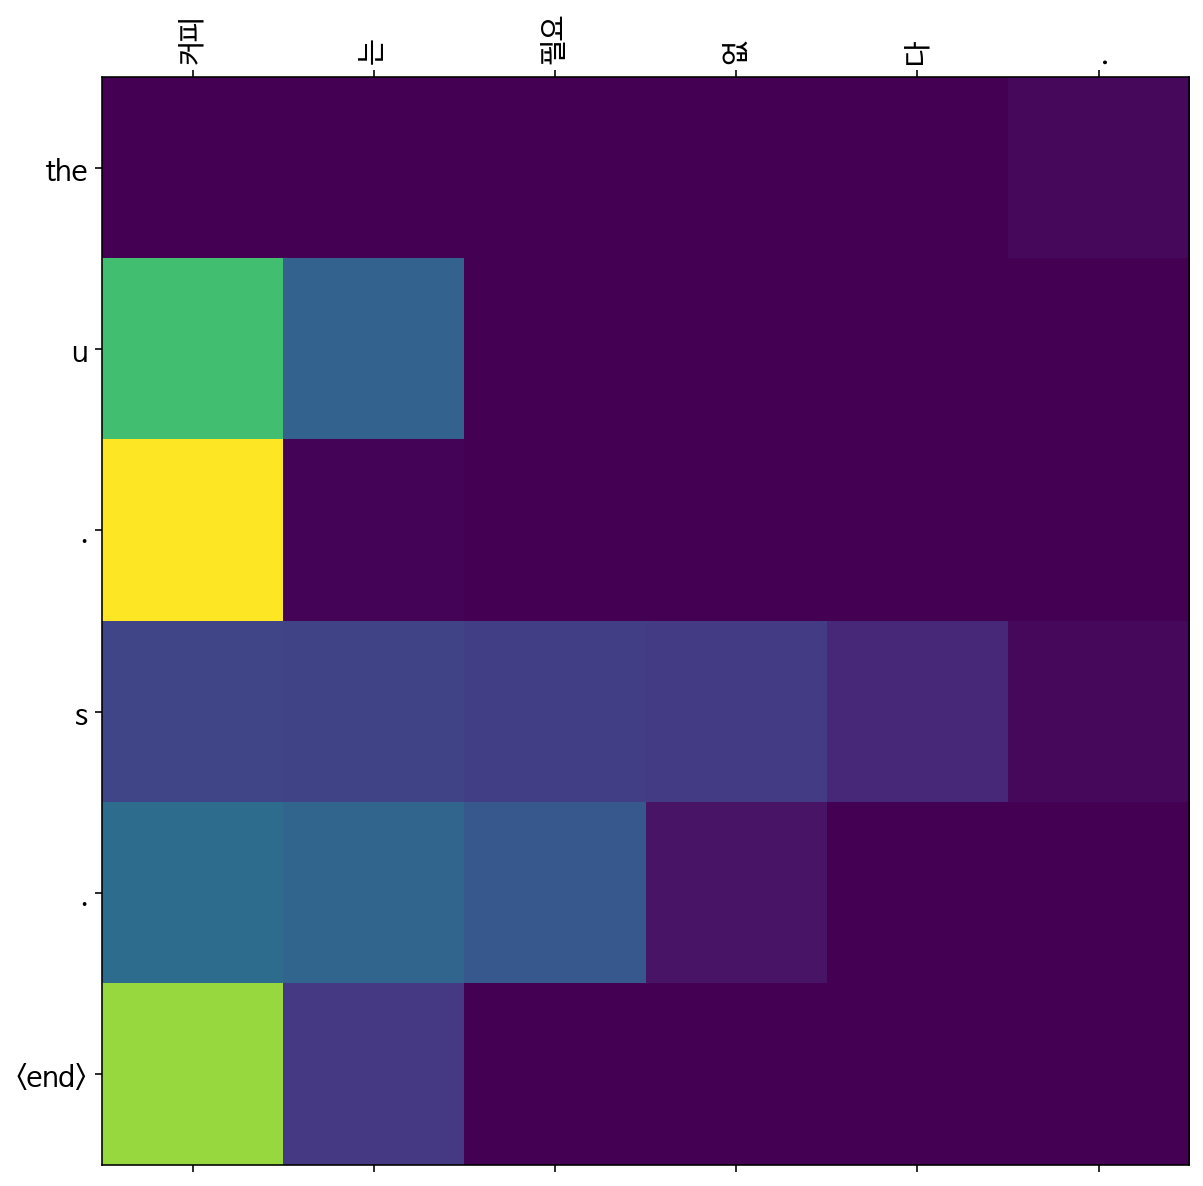

In [23]:
translate("커피는 필요 없다.", encoder, decoder)

Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다', '.']
Predicted translation: the teachers in the u . s . <end> 


/tmp/ipykernel_415/2245781914.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_415/2245781914.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


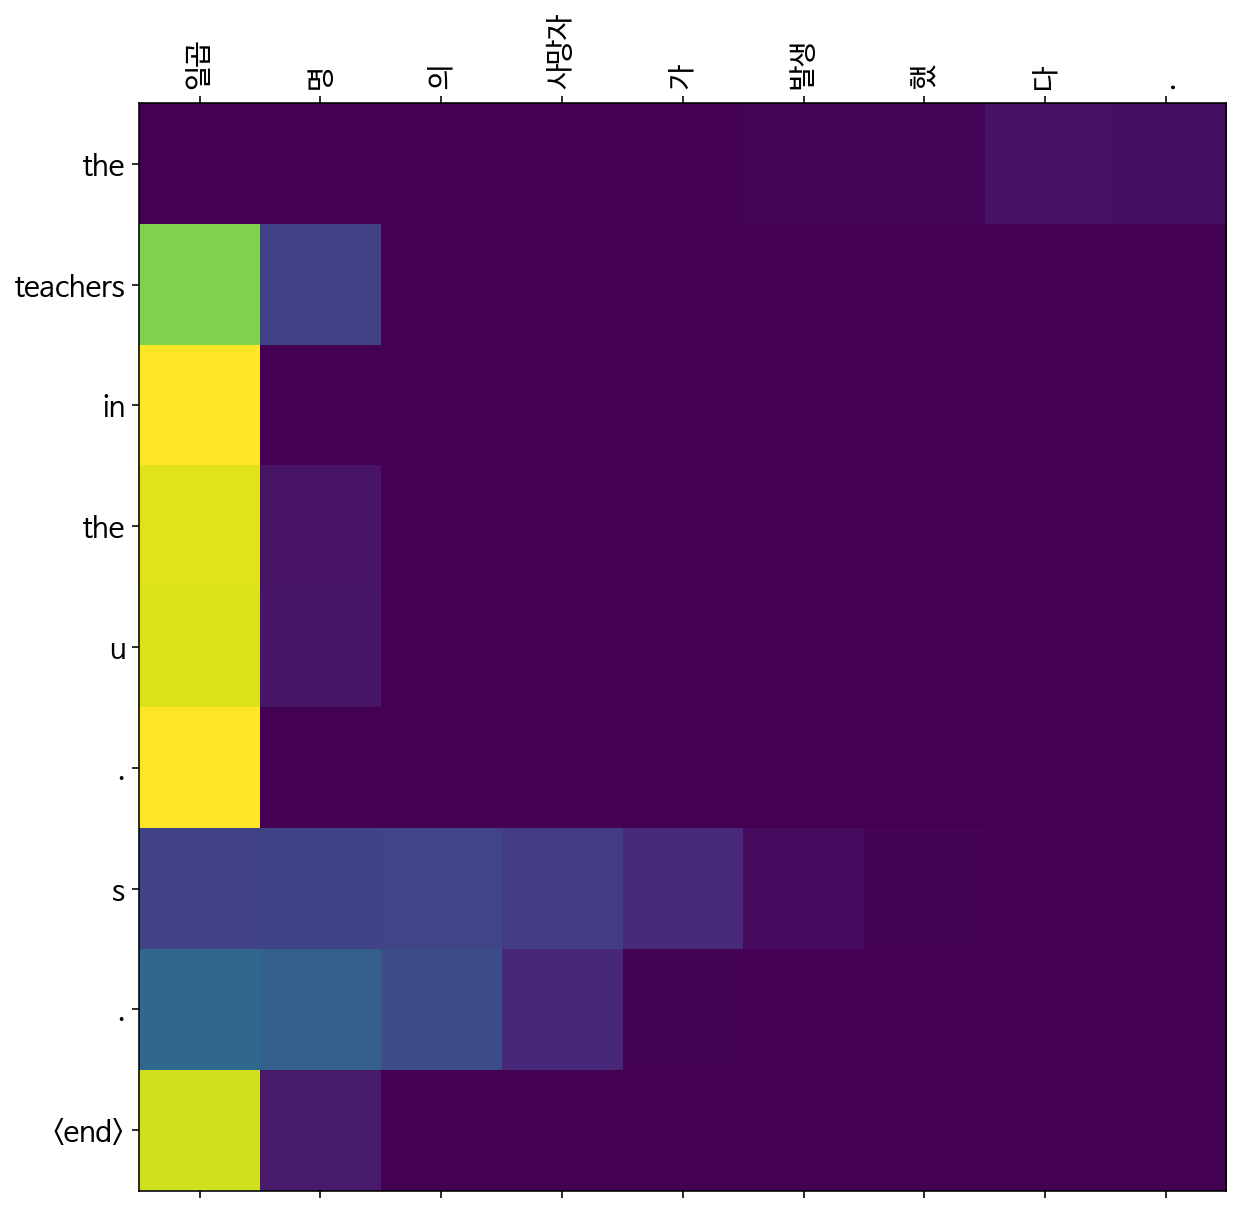

In [24]:
translate("일곱 명의 사망자가 발생했다.", encoder, decoder)

# 회고

* 결과가 상당히 안좋게 나왔다.
* 코랩으로 했을 때는 같은 코드인데도 the로만 번역하는 현상이 발생해서 어쩔 수 없이 lms로 돌렸다.
* 어텐션에 대한 이론은 모두 안다고 생각했지만, 실제로 코드를 짜보려고하니 막막하여 이곳저곳에서 참고를 많이 했다.
* 로스값이 용캐 잘 줄어든게 신기할 정도로 이해되지 않는 부분이 많아서 자투리 시간에 바다나우 어텐션 부분과 이와 유사한 부분에 설명을 해주는 곳을 찾아봐야 할 것 같다.

* 위의 사항을 제외하고 기억에 남았던 것은 토큰화 후에 set을 했던 결과였다.
* 토큰화를 하고 set을 사용했더니 대부분의 단어가 삭제되어서 원인을 알아내느라 고생을 많이 했다. 순서를 꼼꼼히 신경써야 할 필요성을 느꼈다.